### 🔍 1. Initial Exploration
- Load the dataset into a **pandas DataFrame**.
- Use the following methods to explore:
  - `.info()`  
  - `.describe()`  
  - `.head()`  
  - `.isnull().sum()`
- Get an overview of:
  - ✅ Data types  
  - ✅ Missing values  
  - ✅ Row counts


In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('dirty_cafe_sales.csv')

In [2]:
# Display basic information about the DataFrame
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (10000, 8)

Column names:
['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date']

First few rows:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [5]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

### 🧹 2. Handle Missing or Placeholder Entries
Identify columns with missing values or placeholders like `"ERROR"`, `"UNKNOWN"`:
- **Item**
- **Quantity**
- **Price Per Unit**
- **Total Spent**
- **Payment Method**
- **Location**
- **Transaction Date**

🔧 Replace `"ERROR"` and `"UNKNOWN"` with **NaN**  
➡️ Then decide: **fill or drop** based on context.

In [6]:
df.replace(["ERROR", "UNKNOWN"], pd.NA, inplace=True)

In [7]:
df.isnull().sum()

Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

In [8]:
df.isna().mean().sort_values(ascending=False)

Location            0.3961
Payment Method      0.3178
Item                0.0969
Price Per Unit      0.0533
Total Spent         0.0502
Quantity            0.0479
Transaction Date    0.0460
Transaction ID      0.0000
dtype: float64

### 🔢 3. Impute Logical Relationships
Use the formula:  
**Total Spent = Quantity × Price Per Unit**

Back-calculate missing values:
- **Price Per Unit = Total Spent / Quantity**
- **Quantity = Total Spent / Price Per Unit**  
  (or infer from average price per item group)

✅ Fill missing values using logic  
🗑️ Drop remaining rows with critical missing data if needed

In [9]:
# Convert 'Total Spent', 'Quantity', and 'Price Per Unit' columns to numeric types, coercing errors to NaN
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')

In [10]:
print("STEP 3: Impute Missing Values Using Logical Relationships ")

# Impute missing Total Spent
missing_total_spent = df['Total Spent'].isnull().sum()
df['Total Spent'] = df['Total Spent'].fillna(
    df['Quantity'] * df['Price Per Unit']
)
print(f"Imputed {missing_total_spent} missing 'Total Spent' values.")

# Impute missing Price Per Unit
missing_price_per_unit = df['Price Per Unit'].isnull().sum()
df['Price Per Unit'] = df['Price Per Unit'].fillna(
    df['Total Spent'] / df['Quantity']
)
print(f"Imputed {missing_price_per_unit} missing 'Price Per Unit' values.")

# Impute missing Quantity
missing_quantity = df['Quantity'].isnull().sum()
df['Quantity'] = df['Quantity'].fillna(
    df['Total Spent'] / df['Price Per Unit']
)
print(f"Imputed {missing_quantity} missing 'Quantity' values.")

STEP 3: Impute Missing Values Using Logical Relationships 
Imputed 502 missing 'Total Spent' values.
Imputed 533 missing 'Price Per Unit' values.
Imputed 479 missing 'Quantity' values.


In [11]:
# Drop rows with critical missing data
critical_missing = df[['Total Spent', 'Quantity', 'Price Per Unit']].isnull().any(axis=1).sum()
df.dropna(subset=['Total Spent', 'Quantity', 'Price Per Unit'], inplace=True)
print(f"Dropped {critical_missing} rows with critical missing data.")

Dropped 58 rows with critical missing data.


In [12]:
# Final check
print("\nFinal missing values by column:")
print(df.isnull().sum())


Final missing values by column:
Transaction ID         0
Item                 963
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3158
Location            3940
Transaction Date     457
dtype: int64


**How to Fill Missing Values in Item, Payment Method, and Location**

1. **Use Mode Imputation**  
   If the missing values are likely random, fill them with the *mode* (most frequent value) of the column.

2. **Use "Unknown" as a Placeholder**  
   If the missingness itself might be meaningful (e.g., indicates a pattern or data collection issue), replace missing values with `"Unknown"` to preserve and track this information.

3. **Use Grouped Mode Imputation**  
   When context matters (e.g., payment method varies by location), perform mode imputation within groups (e.g., mode of Payment Method *within each Location*) for more accurate and context-aware filling.

In [13]:
df['Payment Method'].value_counts()

Payment Method
Digital Wallet    2280
Credit Card       2260
Cash              2244
Name: count, dtype: int64

**1. **`Payment Method`** (3,158 missing values)**

This is a **categorical variable** with a small set of known values (e.g., *Cash*, *Credit Card*, *Digital Wallet*).

**Recommended Strategy: Fill with Mode**  
Since the missing values are likely random and the category set is limited, replacing with the most frequent value is both safe and effective.

> 💡 **Why?** The mode preserves the overall distribution and reflects the most common customer behavior.


In [14]:
df['Payment Method'].fillna(df['Payment Method'].mode()[0], inplace=True)

**2. **`Location`** (3,940 missing values)**

This may have many unique values (e.g., store branches, cities), and missingness could indicate a data collection gap.

**Fill with `"Unknown"`**
> ✅ Simple, transparent, and avoids introducing bias.

In [15]:
df['Location'].fillna('Unknown', inplace=True)

In [16]:
print(df.isnull().sum())

Transaction ID        0
Item                963
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method        0
Location              0
Transaction Date    457
dtype: int64


In [17]:
df['Item'].value_counts()

Item
Juice       1167
Coffee      1158
Salad       1144
Cake        1134
Sandwich    1122
Smoothie    1089
Cookie      1084
Tea         1081
Name: count, dtype: int64

To impute missing values in the `Item` column — where each entry represents a product (e.g., *Juice*, *Coffee*, etc.) — we need to handle `NaN`s **intelligently** to avoid distorting the data distribution.

Choosing the Right Strategy to impute the item nan values

| Strategy                 | When to Use                                                                 | Pros & Cons |
|--------------------------|------------------------------------------------------------------------------|-------------|
| ⚖️ **Proportional Sampling** | ✅ Best for accurate analysis, modeling, or reporting                        | ✔️ Preserves real distribution<br>❌ Slightly more complex |
| 🥇 **Fill with Mode**       | ✅ Acceptable for quick fixes or low-missingness scenarios                   | ✔️ Simple and fast<br>❌ Introduces bias |

In [18]:
# Get item frequencies as probabilities
item_distribution = df['Item'].value_counts(normalize=True)

# Identify indices where Item is missing
missing_indices = df[df['Item'].isna()].index

# Randomly sample items based on their real-world proportions
imputed_values = np.random.choice(
    item_distribution.index,
    size=len(missing_indices),
    p=item_distribution.values
)

# Assign imputed values back to the DataFrame
df.loc[missing_indices, 'Item'] = imputed_values

In [19]:
df.isna().sum()

Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method        0
Location              0
Transaction Date    457
dtype: int64

### 📅 4. Normalize Date Column
- Convert **Transaction Date** to `datetime` type
- If dates are missing or inconsistent:
  - Sort by transaction date
  - Use **forward-fill** or **backward-fill** to impute
- Ensure all dates are in a **consistent format** recognized by pandas

In [20]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
# errors='coerce' turns invalid or inconsistent formats into NaT (missing datetime).

In [21]:
missing_dates = df['Transaction Date'].isna().sum()
print(f"Missing or invalid dates: {missing_dates}")


Missing or invalid dates: 457


In [22]:
df.sort_values('Transaction Date', inplace=True)


In [23]:
# Impute missing dates
df['Transaction Date'].fillna(method='ffill', inplace=True)  # or use 'bfill'

In [24]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
1425,TXN_8842223,Sandwich,5.0,4.0,20.0,Digital Wallet,In-store,2023-01-01
7309,TXN_6093955,Tea,5.0,1.5,7.5,Digital Wallet,Takeaway,2023-01-01
7285,TXN_1604072,Coffee,2.0,2.0,4.0,Digital Wallet,Unknown,2023-01-01
2726,TXN_2024598,Sandwich,1.0,4.0,4.0,Digital Wallet,In-store,2023-01-01
9356,TXN_2104473,Cake,3.0,3.0,9.0,Digital Wallet,Takeaway,2023-01-01


In [25]:
df.isna().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

### 🔤 5. Standardize Categorical Columns
Clean up:
- **Item**
- **Payment Method**
- **Location**

✅ Normalize casing (e.g., all lowercase or uppercase)  
✅ Strip whitespace and remove unwanted symbols  
✅ Replace inconsistent labels with consistent ones:
  - e.g., `"card"`, `"cash"`, `"unknown"`

In [26]:
# Clean Item Column

# Remove leading/trailing spaces
df['Item'] = df['Item'].str.strip()
# Convert to lowercase
df['Item'] = df['Item'].str.lower()
# Remove special characters (keep only letters, numbers, and spaces)
df['Item'] = df['Item'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [27]:
#  Clean Payment Method Column

# Convert to string
df['Payment Method'] = df['Payment Method'].astype(str)
# Remove leading/trailing spaces
df['Payment Method'] = df['Payment Method'].str.strip()
# Convert to lowercase
df['Payment Method'] = df['Payment Method'].str.lower()
# Remove special characters
df['Payment Method'] = df['Payment Method'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [28]:
#  Clean Location Column

# Convert to string
df['Location'] = df['Location'].astype(str)
# Remove leading/trailing spaces
df['Location'] = df['Location'].str.strip()
# Convert to lowercase
df['Location'] = df['Location'].str.lower()
# Remove special characters
df['Location'] = df['Location'].str.replace(r'[^a-z0-9\s]', '', regex=True)

### 🚫 6. Remove Duplicates
- Use `.drop_duplicates()` to remove duplicate transaction rows
- Ensure **no repeated Transaction ID** values

🔎 Why both steps?

| Step                          | Purpose                                                              |
| ----------------------------- | -------------------------------------------------------------------- |
| `drop_duplicates()`           | Removes **entirely identical rows**                                  |
| `drop_duplicates(subset=...)` | Ensures **unique identifiers** like `Transaction ID` aren’t repeated |


In [29]:
# Step 1: Remove Entire Duplicate Rows
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed {before - after} fully duplicated rows.")

Removed 0 fully duplicated rows.


In [30]:
# Step 2: Ensure No Repeated Transaction ID Values
duplicate_ids = df['Transaction ID'].duplicated().sum()
print(f"Found {duplicate_ids} duplicate Transaction IDs.")

# Drop duplicates based only on Transaction ID (keep the first occurrence)
df.drop_duplicates(subset='Transaction ID', keep='first', inplace=True)


Found 0 duplicate Transaction IDs.



### 🔁 7. Type Conversion & Validation
- Convert numeric columns to correct types:
  - **Quantity**, **Price Per Unit**, **Total Spent** → `float` or `int`
- Check for:
  - ❌ Negative values
  - ❌ Nonsensical entries (e.g., zero quantity, negative price)
- Handle them appropriately

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9942 entries, 1425 to 9988
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    9942 non-null   object        
 1   Item              9942 non-null   object        
 2   Quantity          9942 non-null   float64       
 3   Price Per Unit    9942 non-null   float64       
 4   Total Spent       9942 non-null   float64       
 5   Payment Method    9942 non-null   object        
 6   Location          9942 non-null   object        
 7   Transaction Date  9942 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 699.0+ KB


In [32]:
# Check for Invalid or Nonsensical Entries
invalid_quantity = df[df['Quantity'] <= 0].shape[0]
invalid_price = df[df['Price Per Unit'] <= 0].shape[0]
invalid_total = df[df['Total Spent'] < 0].shape[0]

print(f"Invalid entries — Quantity ≤ 0: {invalid_quantity}, Price ≤ 0: {invalid_price}, Total < 0: {invalid_total}")


Invalid entries — Quantity ≤ 0: 0, Price ≤ 0: 0, Total < 0: 0


### 📊 8. Outlier Detection (Optional)
- Plot or calculate statistical summaries
- Detect outliers in:
  - **Quantity**
  - **Total Spent**
  - **Price Per Unit**
- Decide: **cap, drop, or investigate** further

In [33]:
# Step 1: Statistical Summary & Visualization
print(df[['Quantity', 'Price Per Unit', 'Total Spent']].describe())

          Quantity  Price Per Unit  Total Spent
count  9942.000000     9942.000000  9942.000000
mean      3.025749        2.947848     8.931855
std       1.420438        1.279897     6.002356
min       1.000000        1.000000     1.000000
25%       2.000000        2.000000     4.000000
50%       3.000000        3.000000     8.000000
75%       4.000000        4.000000    12.000000
max       5.000000        5.000000    25.000000


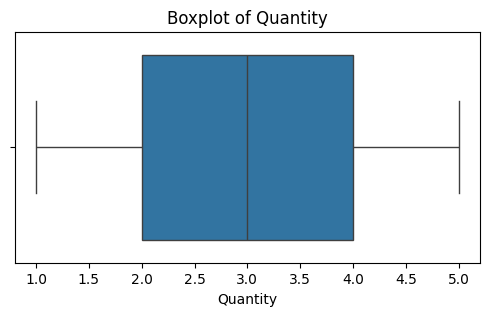

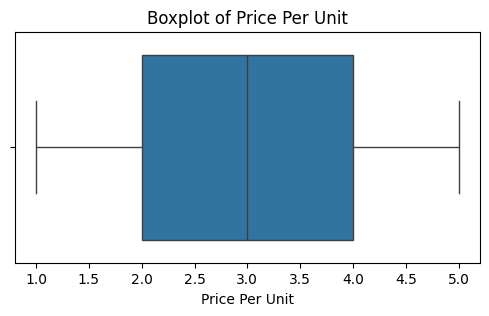

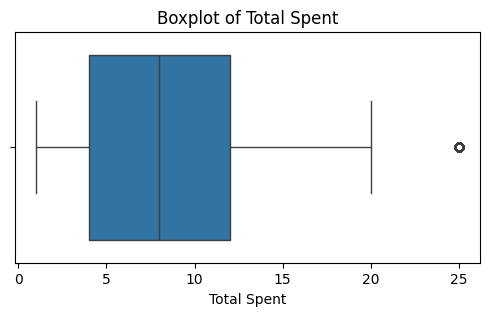

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


We see that from the box plot the Total Spent column is the one that has outliers

In [35]:
# Step 2: Detect Outliers Using Interquartile Range (IQR) Method
for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f"{col}: {outliers} outliers")


Quantity: 0 outliers
Price Per Unit: 0 outliers
Total Spent: 267 outliers


**Step 3: Handle Outliers — Options**

| Option              | When to Use                                                 | How to Apply                                                   |
| ------------------- | ----------------------------------------------------------- | -------------------------------------------------------------- |
| **Drop**            | If the outliers are likely data errors or unrealistic       | `df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]` |
| **Cap (Winsorize)** | If you want to reduce impact but keep them                  | Replace outliers with boundaries                               |
| **Investigate**     | If the values could be real but extreme (e.g., bulk orders) | Mark or review them before deciding                            |


In [36]:
# Cap (Winsorize)
df['Total Spent'] = df['Total Spent'].clip(lower=lower_bound, upper=upper_bound)

### ⚙️ 9. Feature Engineering & Derived Columns
Optionally create new features:
- **Revenue per Transaction** (= Total Spent)
- **Month**, **Weekday**, or **Hour** from Transaction Date
- Grouped features like:
  - `avg_price_per_item`
  - `location_category`

💡 **Feel free to add your own ideas!** That would be great! 🎉

In [37]:
# Date-based Features (from Transaction Date)
df['Month'] = df['Transaction Date'].dt.month
df['Weekday'] = df['Transaction Date'].dt.day_name()
df['Hour'] = df['Transaction Date'].dt.hour

In [38]:
# Price per Item Group 
df['Avg Price per Item'] = df.groupby('Item')['Price Per Unit'].transform('mean')

In [39]:
# Price Diff from Avg Detect if a price is above/below the average per item	
df['Price Diff'] = df['Price Per Unit'] - df['Avg Price per Item']

In [40]:
# Is Weekend Helps analyze behavior on weekends	
df['Is Weekend'] = df['Weekday'].isin(['Saturday', 'Friday'])

In [41]:
# High Revenue Flag	Flags big purchases for analysis	
df['High Revenue'] = df['Total Spent'] > df['Total Spent'].quantile(0.90)

In [42]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Month,Weekday,Hour,Avg Price per Item,Price Diff,Is Weekend,High Revenue
1425,TXN_8842223,sandwich,5.0,4.0,20.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
7309,TXN_6093955,tea,5.0,1.5,7.5,digital wallet,takeaway,2023-01-01,1,Sunday,0,1.658717,-0.158717,False,False
7285,TXN_1604072,coffee,2.0,2.0,4.0,digital wallet,unknown,2023-01-01,1,Sunday,0,2.084706,-0.084706,False,False
2726,TXN_2024598,sandwich,1.0,4.0,4.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
9356,TXN_2104473,cake,3.0,3.0,9.0,digital wallet,takeaway,2023-01-01,1,Sunday,0,2.987159,0.012841,False,False


In [43]:
df.tail()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Month,Weekday,Hour,Avg Price per Item,Price Diff,Is Weekend,High Revenue
9933,TXN_9460419,cake,1.0,3.0,3.0,digital wallet,takeaway,2023-12-31,12,Sunday,0,2.987159,0.012841,False,False
9937,TXN_8253472,cake,1.0,3.0,3.0,digital wallet,unknown,2023-12-31,12,Sunday,0,2.987159,0.012841,False,False
9949,TXN_3130865,juice,3.0,3.0,9.0,digital wallet,instore,2023-12-31,12,Sunday,0,3.002705,-0.002705,False,False
9983,TXN_9226047,smoothie,3.0,4.0,12.0,cash,unknown,2023-12-31,12,Sunday,0,3.894912,0.105088,False,False
9988,TXN_9594133,cake,5.0,3.0,15.0,digital wallet,unknown,2023-12-31,12,Sunday,0,2.987159,0.012841,False,False


In [44]:
# Step 1: Reset the current index (if it's not default already)
df.reset_index(drop=True, inplace=True)
# Step 2: Set 'Transaction ID' as the new index
df.set_index('Transaction ID', inplace=True)

In [45]:
print(df.index.name)  # Should print: Transaction ID

Transaction ID


In [46]:
df.head()

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Month,Weekday,Hour,Avg Price per Item,Price Diff,Is Weekend,High Revenue
Transaction ID,,,,,,,,,,,,,,
TXN_8842223,sandwich,5.0,4.0,20.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
TXN_6093955,tea,5.0,1.5,7.5,digital wallet,takeaway,2023-01-01,1,Sunday,0,1.658717,-0.158717,False,False
TXN_1604072,coffee,2.0,2.0,4.0,digital wallet,unknown,2023-01-01,1,Sunday,0,2.084706,-0.084706,False,False
TXN_2024598,sandwich,1.0,4.0,4.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
TXN_2104473,cake,3.0,3.0,9.0,digital wallet,takeaway,2023-01-01,1,Sunday,0,2.987159,0.012841,False,False


In [47]:
df.reset_index(inplace=True)  # 'Transaction ID' becomes a column again
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Month,Weekday,Hour,Avg Price per Item,Price Diff,Is Weekend,High Revenue
0,TXN_8842223,sandwich,5.0,4.0,20.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
1,TXN_6093955,tea,5.0,1.5,7.5,digital wallet,takeaway,2023-01-01,1,Sunday,0,1.658717,-0.158717,False,False
2,TXN_1604072,coffee,2.0,2.0,4.0,digital wallet,unknown,2023-01-01,1,Sunday,0,2.084706,-0.084706,False,False
3,TXN_2024598,sandwich,1.0,4.0,4.0,digital wallet,instore,2023-01-01,1,Sunday,0,3.890176,0.109824,False,False
4,TXN_2104473,cake,3.0,3.0,9.0,digital wallet,takeaway,2023-01-01,1,Sunday,0,2.987159,0.012841,False,False
